用来测试手搓函数实现多个颜色mask


确认了只能画一个mask一次。
In `MNE-Python`, the `Evoked.plot_topomap()` function allows plotting a topomap with optional masking (e.g., highlighting significant sensors). However, it only accepts a **single `mask` array**, which is a boolean 2D array of shape `(n_channels, n_times)`.


肯定是需要魔改代码了，

idea:另外写一个函数就可以，找到源码给gpt，问题是还得测试一下，需要gpt提供

Reading C:\Users\Administrator\mne_data\MNE-sample-data\MEG\sample\sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left Auditory)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)


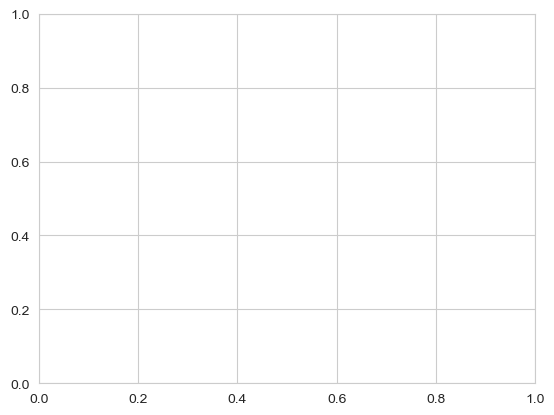

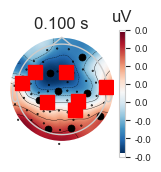

In [7]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mne.viz.topomap import _prepare_topomap_plot  # 私有函数，注意版本变更风险

# === 1. 加载 MNE 示例数据 ===
sample_data_folder = Path(mne.datasets.sample.data_path())
sample_data_raw_file = sample_data_folder / 'MEG' / 'sample' / 'sample_audvis-ave.fif'
evoked = mne.read_evokeds(str(sample_data_raw_file), condition='Left Auditory', baseline=(None, 0))

# === 2. 选择 EEG 通道 ===
evoked.pick('eeg')

# === 3. 设置目标时间点（单位：秒）===
time_point = 0.1  # 100 ms
time_idx = evoked.time_as_index(time_point)[0]  # 获取该时间点在 data 中的列索引

# === 4. 获取维度信息 ===
n_channels, n_times = evoked.data.shape

# === 5. 随机构造两个掩码（每个只在一个时间点有效）===
rng = np.random.RandomState(42)
mask1 = np.zeros((n_channels, n_times), dtype=bool)
mask2 = np.zeros((n_channels, n_times), dtype=bool)
mask1[:, time_idx] = rng.rand(n_channels) < 0.1  # 10% 显著
mask2[:, time_idx] = rng.rand(n_channels) < 0.1  # 另一组显著通道

# === 6. 绘制 topomap（含 mask1 黑圈）===
fig, ax = plt.subplots()
evoked.plot_topomap(
    times=[time_point],
    show=False,
    mask=mask1,
    mask_params=dict(marker='o', markersize=10, markerfacecolor='k'),
    colorbar=True,
    cmap='RdBu_r',
    vlim=(np.min(evoked.data), np.max(evoked.data)),
    units='uV',
    scalings=1,
    time_unit='s'
)

# === 7. 获取 topomap 上通道坐标，并叠加 mask2（红方块）===
fig = plt.gcf()
ax = fig.axes[0]  # 跳过 colorbar 的 axes

# 获取通道位置（私有函数，但常用）
_, pos, *_ = _prepare_topomap_plot(evoked, ch_type='eeg', sphere=None)

# 在对应的显著通道位置绘制红色方块
for i in np.where(mask2[:, time_idx])[0]:
    x, y = pos[i]
    ax.plot(x, y, 's', markersize=10, markerfacecolor='red', markeredgecolor='red')

plt.show()


Reading C:\Users\Administrator\mne_data\MNE-sample-data\MEG\sample\sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left Auditory)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)


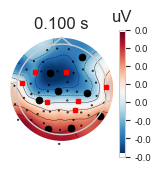

In [9]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mne.viz.topomap import _prepare_topomap_plot  # 私有函数，用于获取通道坐标

# === 1. 加载 MNE 示例数据 ===
sample_data_folder = Path(mne.datasets.sample.data_path())
sample_data_raw_file = sample_data_folder / 'MEG' / 'sample' / 'sample_audvis-ave.fif'
evoked = mne.read_evokeds(str(sample_data_raw_file), condition='Left Auditory', baseline=(None, 0))

# === 2. 只使用 EEG 通道 ===
evoked.pick('eeg')

# === 3. 设置绘图时间点（秒）===
time_point = 0.1  # 即 100ms
time_idx = evoked.time_as_index(time_point)[0]  # 找到该时间点在 data 中的位置

# === 4. 随机构造两个显著性 mask，只在 time_idx 处为 True ===
n_channels, n_times = evoked.data.shape
rng = np.random.RandomState(42)
mask1 = np.zeros((n_channels, n_times), dtype=bool)
mask2 = np.zeros((n_channels, n_times), dtype=bool)
mask1[:, time_idx] = rng.rand(n_channels) < 0.1  # 10% 随机显著通道
mask2[:, time_idx] = rng.rand(n_channels) < 0.1

# === 5. 使用 MNE 自动生成图并绘制 mask1 ===
fig = evoked.plot_topomap(
    times=[time_point],
    show=False,
    mask=mask1,
    mask_params=dict(marker='o', markersize=10, markerfacecolor='k'),
    colorbar=True,
    cmap='RdBu_r',
    vlim=(np.min(evoked.data), np.max(evoked.data)),
    units='uV',
    scalings=1,
    time_unit='s'
)

# === 6. 叠加第二个 mask（红色方块） ===
ax = fig.axes[0]  # 获取 topomap 主图的 axes（跳过 colorbar）

# 获取通道坐标（使用私有函数）
_, pos, *_ = _prepare_topomap_plot(evoked, ch_type='eeg', sphere=None)

# 在对应通道坐标位置叠加红色方块（mask2）
for i in np.where(mask2[:, time_idx])[0]:
    x, y = pos[i]
    ax.plot(x, y, 's', markersize=3, markerfacecolor='red', markeredgecolor='red')

plt.show()
